In [1]:
import os
import random, os
import numpy as np
import torch
import importlib
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import vae, fg, bg
from objVAE import objVAE, MultiheadAttention

    
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

2023-10-16 15:10:56.716924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:10:58.310994: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [2]:
image_size = 64

def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(model, combine_radius, plot_num=0, num_entities=10, pres_floor=0.25, tra_floor=0.25):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        recon = recon.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()
        xy = xy.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(xy.shape[0]):

            xp = xy[i, :, 0]
            yp = xy[i, :, 1]

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            pres_mask = pres[i] <= pres_floor

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(xy.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(recon[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            if i_seq == plot_num:
                print(new_attention)

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            #binary_attention = np.where(new_attention >= tra_floor, 1, 0)

            tp = np.sum(gt_attention.astype(bool) & binary_attention.astype(bool))
            fp = np.sum(binary_attention.astype(bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(bool) & ~binary_attention.astype(bool)
            )
            fn = np.sum(~binary_attention.astype(bool)) - tn

            mse_total.append(mse)
            if (false_detections + true_detections):
                false_detections_total.append(
                    false_detections / (false_detections + true_detections)
                )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.where(binary_attention == 1)
                #cols = np.argmax(binary_attention, axis=1)
                for i_col, _ in enumerate(cols[0]):
                    previous = cols[0][i_col]
                    current = cols[1][i_col]
                    if remove_map_v[i - 1][previous] or remove_map_v[i][current]:
                        continue
                    x_line = [xp_v[i - 1][previous], xp_v[i][current]]
                    y_line = [yp_v[i - 1][previous], yp_v[i][current]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }


def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        recon, indices, pres, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        alpha = pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(pres[0, alpha].detach().cpu().numpy())

    else:
        recon, indices, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    if trainer:
        if trainer.current_epoch % 50 == 0:
            plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

torch.Size([400, 1, 256, 256])


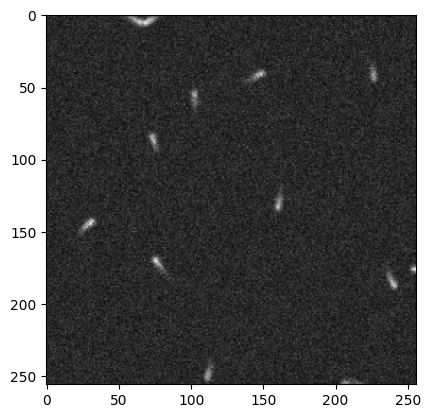

In [27]:
import tifffile
from glob import glob

x_crop = 256
y_crop = 256

paths = r'/data/mp_mpa/microtubule-sn7-low/*.tif'
paths = glob(paths)

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)
#images = np.array(np.split(images, 20, axis=0))

images_array = []
for i in range(images.shape[1] // x_crop):
    for j in range(images.shape[2] // y_crop):
        images_array.append(images[:, (i)*x_crop:(i+1)*x_crop, (j)*y_crop:(j+1)*y_crop])


images = np.concatenate(images_array, axis=0)

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(0, 1, 2), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=1)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[8,:,:,:]), cmap='gray')



In [28]:
train, test = torch.utils.data.random_split(training_images, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(training_images, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=2, shuffle=False)

In [29]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, presence, bg, fgs, xy, latents_fg, kl_bg, kl_fg = model(x)
    fg1, fg2 = fgs[:2]
    print(xy.shape, presence.shape)
    alpha = presence[0].detach().cpu().numpy() > 0.25
    xy = xy.detach().cpu().numpy()[0, alpha]

    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolor="r", facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    
    plt.subplot(2, 2, 3)
    plt.imshow(
        fg1[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 1")
    
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        fg2[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("FG 2")

    return plt

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

fg_params = {
    'decoder_activation': 'relu',
    'decoder_feature_size': 56,
    'decoder_norm': 'none',
    'decoder_norm_first': True,
    'decoder_num_layers': 4,
    'glimpse_size': 16,
    'latent_dim': 16,
    'position_embedding': 'radial',
    'position_prediction_scale': 1,
    'position_representation_scale': 1,
    'position_embedding_dim': 1,
    'num_entities': 10,
    'encoder_depth': 3,
    'topk_select_method': "max"
}

fg_model = fg.objFG(**fg_params)
bg_model = bg.objBG(in_channels=1,image_size=128, **bg_params)
model = vae.objVAE(bg_model=bg_model, fg_model=fg_model, beta=1e-9, learning_rate=8e-4)

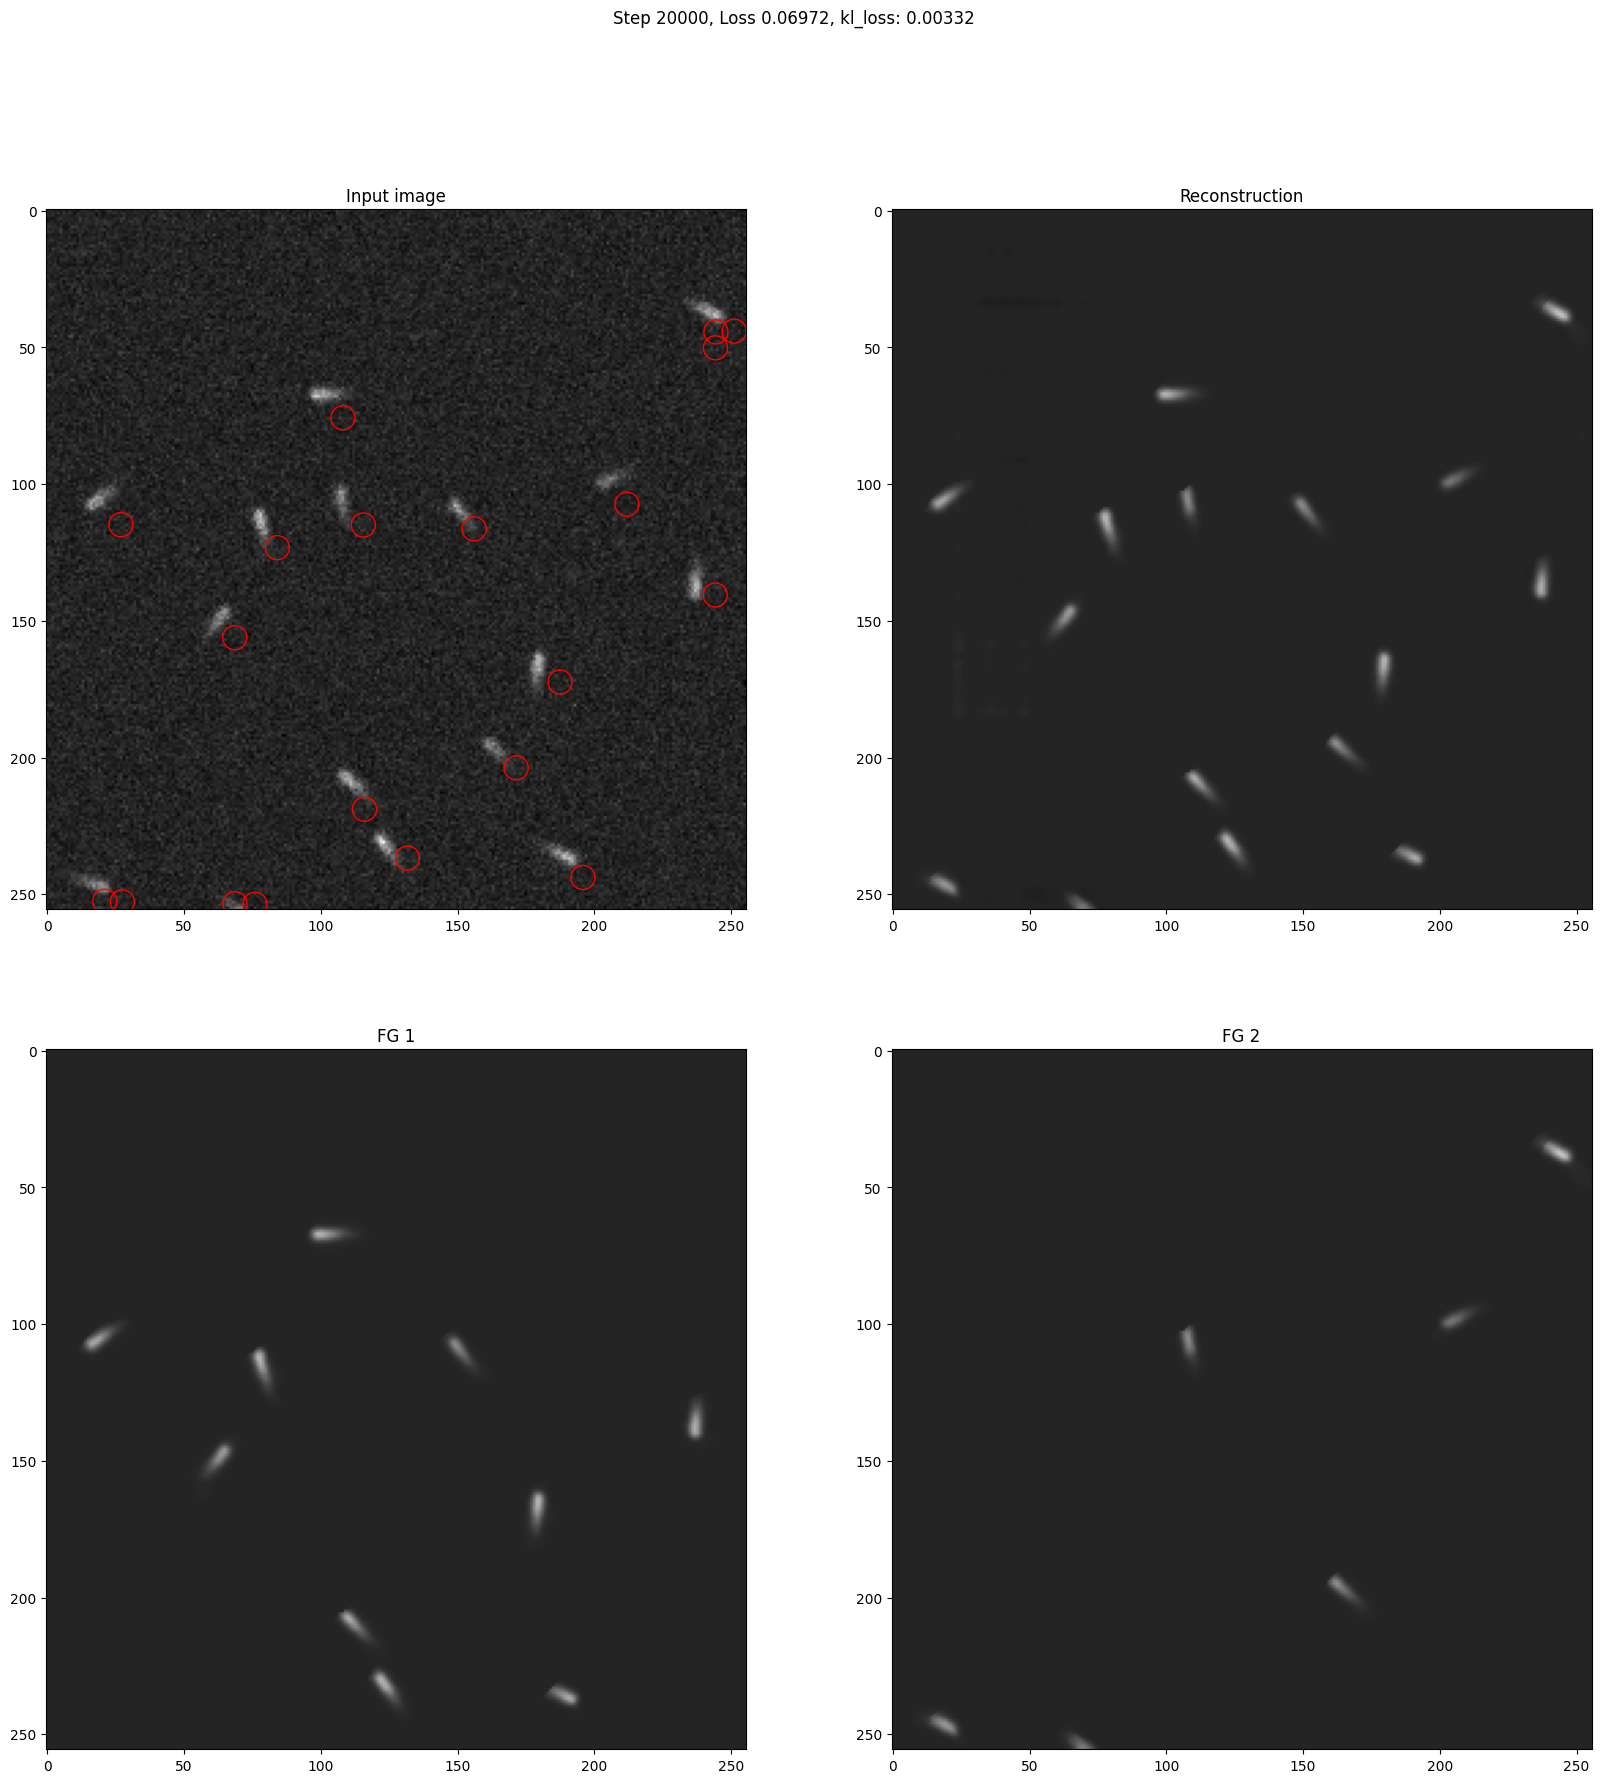

Epoch 99: 100%|██████████| 200/200 [00:07<00:00, 27.04it/s]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 99: 100%|██████████| 200/200 [00:07<00:00, 26.91it/s]


In [30]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
import pytorch_lightning as pl
#import optuna

max_steps = 20000

# Annealing beta (weighting of kl-term of loss) helps 
# avoid mode collapse where every parameter is unit gaussian.
beta_annealing_end = 1800

# Annealing learning rate helps push the ELBO pareto frontier
lr_annealing_end = max_steps

# KL importance annealing makes the network sample latents based on
# residual error from background model early in training, to increase
# stability
kl_annealing_end = 2400

# Presence annealing biases the network towards saying that a latent is
# an object early in training (to avoid collapse where nothing is a object)
# and biases towards saying latents are not an object late in training
# (to avoid multiple detections of the same objects)
presence_annealing_end = 1000

class PlottingCallback(pl.Callback):


    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:

        
        loss = trainer.callback_metrics["reconstruction_epoch"]
        kl = trainer.callback_metrics["kl_epoch"]
        plot(model, train_loader)
        plt.suptitle(f"Step {trainer.global_step}, Loss {loss:.5f}, kl_loss: {kl:.5f}")
        ipd.clear_output(wait=True)
        plt.show()

        
def beta_annealing(step):
    logs = np.logspace(-4, -2.5, beta_annealing_end)
    if step >= beta_annealing_end:
        return logs[-1]
    else:
        return logs[int(step)]

def kl_annealing(step):
    logs = np.linspace(1, 1, kl_annealing_end)
    if step < 500:
        return 0

    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def presence_bias_annealing(step):
    logs = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return logs[step]
    else:
        return 0
    
class Annealing(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        step = trainer.global_step
        
        pl_module.beta = beta_annealing(step)
        pl_module.fg_model.kl_importance = kl_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.presence_bias = presence_bias_annealing(step)

trainer = pl.Trainer(
    max_steps=max_steps,
    callbacks=[PlottingCallback(), Annealing()],
    logger=False,
#     check_val_every_n_epoch=1000,
)

# model.fg_model.topk_select_method = "random"
trainer.fit(model, train_loader)

# evaluate
#test_results = trainer.test(model, test_loader)